# Library Loading


In [1]:

import cv2
import os
import numpy as np
import configparser
import sys
from scipy.integrate import solve_ivp
from scipy.fft import fft, fftfreq
from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import SymLogNorm
import matplotlib.mlab
import matplotlib as mpl
import scipy.io as sio
import pandas as pd
import scipy.optimize as optim
from scipy.optimize import curve_fit
from scipy import interpolate
from scipy import fft, arange, signal
# from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

mpl.rcParams["lines.linewidth"] = 1.5
mpl.rcParams["savefig.bbox"] = "tight"
mpl.rcParams["figure.figsize"] = (16, 10)
mpl.rcParams["font.size"] = 15
mpl.rcParams["legend.frameon"] = False
# INPUT PARAMETERS


# Function Definition

In [15]:

def model(time, length, pulse):
    # heat capacity, incoming radiation
    # Earth heat capacity
    cearth = 0.3725
    # Incoming radiation
    Q0 = 342.5

    # land fraction and albedo
    # Fraction of land on the planet
    p = 0.3
    # land albedo
    alphaland = 0.28

    # outgoing radiation linearized
    kappa = 1.74
    Tkappa = 154

    # CO2 radiative forcing
    # Greenhouse effect parameter
    B = 5.35
    # CO2 params. C0 is the reference C02 level
    C0 = 280

    # ocean carbon pumps
    # Solubility dependence on temperature (value from Fowler et al)
    bP = 0.029
    # Biopump dependence on temperature (Value from Fowler)
    bB = 0.069
    # Ocean carbon pump modulation parameter
    cod = 2.2

    # timescale and reference temperature (from Fowler)
    # timescale
    tauc = 30
    # Temperature reference
    T0 = 288

    # Coc0 ocean carbon depending on depth
    coc0 = 330

    # CO2 uptake by vegetation
    wa = 0.006
    #vegcover = 0.4
    Thigh = 307.15
    Tlow = 286.15
    Topt1 = 286.15
    Topt2 = 302.15
    acc = 8

    # Volcanism
    V = 0.028

    # Anthropogenic carbon
    # Switch to take anthropogenic emissions
    sa = 1
    # Anthropogenic emissions (zero or one)
    file_name = "newbaseline"
    # time = 245
    # pulse = 25
    # Can = pd.read_csv("./nonlinearCarbon/data/"+file_name+".csv")
    # #Can = pd.read_csv("Et-sim2.csv")
    # #times2co2eq
    # #rcp85co2eq.csv
    # #Ca = Can[(Can["YEARS"] > 1899) & (Can["YEARS"] < 2201)]
    # #Ca = Can[(Can["YEARS"] > 1799) & (Can["YEARS"] < 2501)]
    # Ca = Can[(Can["YEARS"] > 1799) & (Can["YEARS"] < 2801)]
    # # Ca = Can[(Can["YEARS"] < 2801)]
    # Ca1 = Can[(Can["YEARS"] > 1799) & (Can["YEARS"] < 2801)]
    # #Ca["YEARS"] = np.arange(start=0,stop=401,step=1)
    # #Ca = Ca.pd.DataFrame()
    # Ca = Ca["CO2EQ"]
    # #Ca = Ca - 286.76808
    # Ca = Ca - 281.69873
    # Ca = Ca.to_numpy()

    tspan = 100
    # Ca = 102.03836999999999*np.ones(tspan)
    # Ca[0] = 0

    # #Ce = np.arange(401)
    # # Ce = np.arange(601)
    # # Ce = np.arange(1001) * 1.0
    # Ce = np.zeros(tspan)
    # #np.min(Ca)
    # for i in range(len(Ce)):
    #     if i == 0:
    #         Ce[i] = 0
    #     else:
    #         Ce[i] = Ca[i] - Ca[i-1]

    # Cebis = np.zeros(tspan) * 1.0
    # #np.min(Ca)
    # for i in range(len(Cebis)):
    #     if i == 0:
    #         Cebis[i] = 0
    #     else:
    #         Cebis[i] = impulse( Ca[i] - Ca[i-1], 0)

    # Cc = np.zeros(tspan) * 1.0
    # #np.min(Ca)
    # for i in range(len(Cc)):
    #     if i == 0:
    #         Cc[i] = 0
    #     else:
    #         Cc[i] = sum(Cebis[0:i])

    #Ce = np.arange(401)
    # Ce = np.arange(601)
    # Ce = np.arange(1001) * 1.0
    Ce = np.zeros(tspan)
    # np.min(Ca)
    for i in range(len(Ce)):
        if i == 0:
            Ce[i] = 0
        elif i > time and i <= time + length:
            Ce[i] = pulse/2.13/length

        else:
            Ce[i] = 0

    Cebis = np.zeros(tspan) * 1.0
    # np.min(Ca)
    for i in range(len(Cebis)):
        if i == 0:
            Cebis[i] = 0
        elif i > time and i <= time + length:
            Cebis[i] = pulse/2.13/length
        else:
            Cebis[i] = 0

    Cc = np.zeros(tspan) * 1.0
    # np.min(Ca)
    for i in range(len(Cc)):
        if i == 0:
            Cc[i] = 217.3417281
        else:
            Cc[i] = 217.3417281 + sum(Cebis[0:i])

    # Ocean albedo parameters
    Talphaocean_low = 219
    Talphaocean_high = 299
    alphaocean_max = 0.85
    alphaocean_min = 0.25

    # Biopump parameters
    #Cbio_low = 100
    #Cbio_high = 700

    # FUNCTIONS

    # Anthropogenic carbon fitting with cubic spline
    t_val = np.linspace(0, tspan-1, tspan)
    #t_val = np.linspace(0, 700, 701)
    # t_val = np.linspace(0, 1000, 1001)

    def Yem(t):
        t_points = t_val
        em_points = Ca

        tck = interpolate.splrep(t_points, em_points)
        return interpolate.splev(t, tck)

    def Yam(t):
        t_points = t_val
        em_points = Ce

        tck = interpolate.splrep(t_points, em_points)
        return interpolate.splev(t, tck)

    def Ycm(t):
        t_points = t_val
        em_points = Cc

        tck = interpolate.splrep(t_points, em_points)
        return interpolate.splev(t, tck)

    #plt.plot(t_val, Ca)
    #plt.plot(t_val, Yem(t_val))

    #plt.plot(t_val, Ce)
    #plt.plot(t_val, Yam(t_val))

    # plt.plot(t_val, Cc)
    # plt.plot(t_val, Ycm(t_val))

    #t_val_v2 = np.linspace(2010, 2800, 1001)
    #tv2 = np.linspace(2010, 2800, 100000)
    #Ycm30 = Ycm(t_val_v2)

    #plt.figure(figsize=(10, 5))
    #plt.plot(tv, Tvmid)

    #plt.plot(t_val_v2[0:600], Ycm[0:600])
    #plt.plot(t_val_v2[0:600], Ycm60[0:600])
    #plt.plot(t_val_v2[0:600], Ycm45[0:600])
    #plt.plot(t_val_v2[0:600], Ycm30[0:600])

    #plt.tick_params(axis='both', which='major', labelsize=18)
    #plt.xlabel('Time (year)',fontsize = 18);
    #plt.ylabel('Temperature annomaly (K)',fontsize = 18);
    # plt.grid(linestyle=':')

    #t_val_v2 = np.linspace(2010, 2800, 1001)
    #plt.plot(t_val_v2[0:600], Yam(t_val)[0:600])
    #plt.tick_params(axis='both', which='major', labelsize=13)
    #plt.xlabel('Time (years)',fontsize = 14);
    #plt.ylabel('Annual emissions (ppm/year)',fontsize = 14);
    # plt.grid(linestyle=':')

    # Ocean albedo
    def alphaocean(T):
        if T < Talphaocean_low:
            return alphaocean_max
        elif T < Talphaocean_high:
            return alphaocean_max + (alphaocean_min - alphaocean_max) / (Talphaocean_high - Talphaocean_low) * (T - Talphaocean_low)
        else:  # so T is higher
            return alphaocean_min

    # T_values = np.linspace(200, 330, 201)
    # plt.plot(T_values, [alphaocean(val) for val in T_values])
    # plt.tick_params(axis='both', which='major', labelsize=13)
    # plt.grid(linestyle=':')
    # plt.xlabel('Temperature (K)',fontsize = 14);
    # plt.ylabel('Ocean albedo',fontsize = 14);

    # Fraction of ocean covered by ice

    def fracseaice(T):
        if T < Talphaocean_low:
            return 1
        elif T < Talphaocean_high:
            return 1 - 1 / (Talphaocean_high - Talphaocean_low) * (T - Talphaocean_low)
        else:  # so T is higher
            return 0

    # plt.plot(T_values, [fracseaice(val) for val in T_values])
    # plt.tick_params(axis='both', which='major', labelsize=13)
    # plt.xlabel('Temperature (K)',fontsize = 14);
    # plt.ylabel('Fraction of sea ice',fontsize = 14);
    # plt.grid(linestyle=':')

    # Biopump modulation

    #Cbio_low = 150
    #Cbio_high = 615

    Cbio_low = 150
    Cbio_high = 750

    # def biopump(Cc):
    #    if Cc < Cbio_low:
    #        return 1
    #    elif Cc < Cbio_high:
    #        return 1 - 1 / (Cbio_high - Cbio_low) * (Cc - Cbio_low)
    # return 1 - 2 / (Cbio_high - Cbio_low) * (Cc - Cbio_low)
    #    else: # so Cc is higher
    #        return 0
    #        #return -1

    #biopump = np.vectorize(biopump)

    #Cc_values = np.linspace(0, 1500, 201)
    #plt.plot(Cc_values, [biopump(val) for val in Cc_values])
    #plt.tick_params(axis='both', which='major', labelsize=13)
    #plt.xlabel('Cumulative anthropogenic emissions (ppm)',fontsize = 14);
    #plt.ylabel('Bio pump efficiency',fontsize = 14);
    # plt.grid(linestyle=':')

    # Time varying biopump modulation

    #plt.plot(t_val, [biopump(val) for val in Ca])
    #plt.tick_params(axis='both', which='major', labelsize=13)
    #plt.xlabel('Time (years)',fontsize = 14);
    #plt.ylabel('Bio pump efficiency',fontsize = 14);
    # plt.grid(linestyle=':')

    # switch between Ca and Cc to allow for reversal of ocean acidity or locking it

    #biomodulation = [biopump(val) for val in Cc]
    #biomod = np.float_(biomodulation)

    # def bioefficiency(t):
    #    t_points = t_val
    #    em_points = biomod

    #    tck = interpolate.splrep(t_points, em_points)
    #    return interpolate.splev(t,tck)

    #plt.plot(t_val, bioefficiency(t_val))
    #plt.tick_params(axis='both', which='major', labelsize=18)
    #plt.xlabel('Time (years)',fontsize = 18);
    #plt.ylabel('Bio pump efficiency',fontsize = 18);
    # plt.grid(linestyle=':')

    #t_val_v2 = np.linspace(2010, 2800, 1001)
    #plt.plot(t_val_v2, bioefficiency(t_val))
    #plt.tick_params(axis='both', which='major', labelsize=18)
    #plt.xlabel('Time (years)',fontsize = 18);
    #plt.ylabel('Bio efficiency',fontsize = 18);
    # plt.grid(linestyle=':')

    #t_val_v2 = np.linspace(2010, 2800, 1001)
    #plt.plot(t_val_v2[0:600], bioefficiency(t_val)[0:600])
    #plt.tick_params(axis='both', which='major', labelsize=18)
    #plt.xlabel('Time (years)',fontsize = 18);
    #plt.ylabel('Bio pump efficiency',fontsize = 18);
    # plt.grid(linestyle=':')

    #t_val_v3 = np.linspace(1, 1, 1001)
    #plt.plot(t_val_v2[0:600], t_val_v3[0:600])
    #plt.tick_params(axis='both', which='major', labelsize=18)
    #plt.xlabel('Time (years)',fontsize = 18);
    #plt.ylabel('Bio pump efficiency',fontsize = 18);
    # plt.grid(linestyle=':')

    # Vegetation growth function

    def veggrowth(T):
        if T < Tlow:
            return 0
        if (T >= Tlow) and (T < Topt1):
            return acc / (Topt1 - Tlow) * (T - Tlow)
        if (T >= Topt1) and (T <= Topt2):
            return acc
        if (T > Topt2) and (T < Thigh):
            # return acc
            return acc / (Topt2 - Thigh) * (T - Thigh)
        if T >= Thigh:
            # return acc
            return 0

    Thigh = 307.15
    Tlow = 286.15
    Topt1 = 290.15
    Topt2 = 302.15
    acc = 8

    # T_values = np.linspace(280, 315, 201)
    # plt.plot(T_values, [veggrowth(val) for val in T_values])
    # plt.tick_params(axis='both', which='major', labelsize=13)
    # plt.xlabel('Temperature (K)',fontsize = 14);
    # plt.ylabel('Vegetation growth',fontsize = 14);
    # plt.grid(linestyle=':')

    # veggrowth(286.6181299517094)
    #veggrowth_vectorized = np.vectorize(veggrowth)
    # veggrowth_vectorized(Tv)

    # veggrowth(Tvmean)
    # veggrowth(Tvmax)
    # veggrowth(Tvmin)
    # veggrowth(Tv)

    Tbiopt1_low = Topt1
    Tbiopt1_high = Topt1 + 5

    #Cbio_low = 150
    #Cbio_high = 600

    def Tbioptlow(Cc):
        if Cc < Cbio_low:
            return Tbiopt1_low
        elif Cc < Cbio_high:
            return Tbiopt1_low + (Tbiopt1_high - Tbiopt1_low) / (Cbio_high - Cbio_low) * (Cc - Cbio_low)
            # return 1 - 2 / (Cbio_high - Cbio_low) * (Cc - Cbio_low)
        else:  # so Cc is higher
            return Tbiopt1_high
            # return -1

    Tbioptlow = np.vectorize(Tbioptlow)

    # Cc_values = np.linspace(0, 1500, 201)
    # plt.plot(Cc_values, [Tbioptlow(val) for val in Cc_values])
    # plt.tick_params(axis='both', which='major', labelsize=13)
    # plt.xlabel('Cumulative anthropogenic emissions (ppm)',fontsize = 14);
    # plt.ylabel('Veg. lower opt. temperature (K)',fontsize = 14);
    # plt.grid(linestyle=':')

    # Time varying biopump modulation

    #plt.plot(t_val, [biopump(val) for val in Ca])
    #plt.tick_params(axis='both', which='major', labelsize=13)
    #plt.xlabel('Time (years)',fontsize = 14);
    #plt.ylabel('Bio pump efficiency',fontsize = 14);
    # plt.grid(linestyle=':')

    # switch between Ca and Cc to allow for reversal of ocean acidity or locking it

    Toptmodulation = [Tbioptlow(val) for val in Cc]
    Toptmod = np.float_(Toptmodulation)

    def Tvegoptlow(t):
        t_points = t_val
        em_points = Toptmod

        tck = interpolate.splrep(t_points, em_points)
        return interpolate.splev(t, tck)

    # t_val_v2 = np.linspace(2010, 2800, 1001)
    # plt.plot(t_val_v2[0:600], Tvegoptlow(t_val)[0:600])
    # plt.tick_params(axis='both', which='major', labelsize=13)
    # plt.xlabel('Time (years)',fontsize = 14);
    # plt.ylabel('Lower opt. temperature (K)',fontsize = 14);
    # plt.grid(linestyle=':')

    # Tbiolow

    Tbiolow_low = Tlow
    Tbiolow_high = Tlow + 5

    #Cbio_low = 150
    #Cbio_high = 600

    def Tbiolow(Cc):
        if Cc < Cbio_low:
            return Tbiolow_low
        elif Cc < Cbio_high:
            return Tbiolow_low + (Tbiolow_high - Tbiolow_low) / (Cbio_high - Cbio_low) * (Cc - Cbio_low)
            # return 1 - 2 / (Cbio_high - Cbio_low) * (Cc - Cbio_low)
        else:  # so Cc is higher
            return Tbiolow_high
            # return -1

    Tbiolow = np.vectorize(Tbiolow)

    # Cc_values = np.linspace(0, 1500, 201)
    # plt.plot(Cc_values, [Tbiolow(val) for val in Cc_values])
    # plt.tick_params(axis='both', which='major', labelsize=13)
    # plt.xlabel('Cumulative anthropogenic emissions (ppm)',fontsize = 14);
    # plt.ylabel('Lower veg. lim temperature (K)',fontsize = 14);
    # plt.grid(linestyle=':')

    # Time varying biopump modulation

    #plt.plot(t_val, [biopump(val) for val in Ca])
    #plt.tick_params(axis='both', which='major', labelsize=13)
    #plt.xlabel('Time (years)',fontsize = 14);
    #plt.ylabel('Bio pump efficiency',fontsize = 14);
    # plt.grid(linestyle=':')

    # switch between Ca and Cc to allow for reversal of ocean acidity or locking it

    Tlowmodulation = [Tbiolow(val) for val in Cc]
    Tlowmod = np.float_(Tlowmodulation)

    def Tveglow(t):
        t_points = t_val
        em_points = Tlowmod

        tck = interpolate.splrep(t_points, em_points)
        return interpolate.splev(t, tck)

    # t_val_v2 = np.linspace(2010, 2800, 1001)
    # plt.plot(t_val_v2[0:600], Tveglow(t_val)[0:600])
    # plt.tick_params(axis='both', which='major', labelsize=13)
    # plt.xlabel('Time (years)',fontsize = 14);
    # plt.ylabel('Lower veg. lim temperature (K)',fontsize = 14);
    # plt.grid(linestyle=':')

    # def vegetationgrowth(T,t):
    #    return veggrowth(T) * bioefficiency(t)

    # Vegetation growth function
    def veggrowthdyn(T, t):
        if T < Tveglow(t):
            return 0
        if (T >= Tveglow(t)) and (T < Tvegoptlow(t)):
            return acc / (Tvegoptlow(t) - Tveglow(t)) * (T - Tveglow(t))
        if (T >= Tvegoptlow(t)) and (T <= Topt2):
            return acc
        if (T > Topt2) and (T < Thigh):
            # return acc
            return acc / (Topt2 - Thigh) * (T - Thigh)
        if T > Thigh:
            # return acc
            return 0

    # Incoming radiation modified by albedo
    def Ri(T):
        return 1/cearth * (Q0 * (1 - p * alphaland - (1 - p) * alphaocean(T)))

    #plt.plot(T_values, [Ri(val) for val in T_values])
    #plt.xlabel('Temperature (K)')
    # plt.grid(linestyle=':')

    # Outgoing radiation modified by greenhouse effect
    def Ro(T, C):
        return 1/cearth * (kappa * (T - Tkappa) - B * np.log(C / C0))

    # Solubility of atmospheric carbon into the oceans
    # carbon pumps
    # def kappaP(T):
    #    np.exp(-bP * (T - T0))

    # def kappaB(T):
    #    np.exp(bB * (T - T0))

    # Sum of two terms that reflect, respectively, the physical (or solubility) carbon pump in the ocean and Wally Broecker’s “biopump”, due to thermally enhanced bioproductivity (Fowler et al., 2013)

    def oceanatmphysflux(T):
        return 1 / tauc * (coc0 * (np.exp(-bP * (T - T0))))

    def oceanbioflux(T):
        return 1/tauc * (coc0 * (np.exp(bB * (T - T0))))

    def oceanatmcorrflux(C):
        return 1 / tauc * (- cod * C)

    # def vegflux(T,C,t):
    #    return wa * bioefficiency(t) * C * vegcover * veggrowth(T)

    # def vegfluxdyn(T,C,t):
    #    return wa * C * vegcover * veggrowthdyn(T,t)

    def vegfluxdyn(T, C, t):
        return wa * C * veggrowthdyn(T, t)

    # def oceanbioflux(T,t):
    #    return 1/tauc * (coc0 * (np.exp(bB * bioefficiency(t) * (T - T0))))

    # MODEL EQUATIONS

    def dydt(t, y):
        T = y[0]
        C = y[1]

        dT = Ri(T)
        dT -= Ro(T, C)

        dC = V
        # anthropogenic emissions from Ca spline                                                # volcanism
        dC += Yam(t) * sa
        # dC += Ca * sa                                       # added for bif diagrams
        # dC -= wa * C * vegcover * veggrowth(T)             # carbon uptake by vegetation
        #dC -= vegflux(T, C, t)
        dC -= vegfluxdyn(T, C, t)
        # physical solubility into ocean * fraction of ice-free ocean
        dC += oceanatmphysflux(T) * (1 - fracseaice(T))
        # dC += oceanbioflux(T,t) * (1 - fracseaice(T))      # biological pump flux * fraction sea ice
        # biological pump flux * fraction sea ice
        dC += oceanbioflux(T) * (1 - fracseaice(T))
        dC += oceanatmcorrflux(C) * (1 - fracseaice(T)
                                     )    # correction parameter

        return dT, dC

    # Integrate the ODE

    sa = 1
    #Ts = 282.9
    # T_2010 = 288.05847735100105, C_2010 = 265.87438476522175, G_2010 = 102.03836999999999

    # Ts = 286.5
    # Cs = 269
    Ts = 288.05847735100105
    Cs = 265.87
    # Cs = 389

    #wa = 0.05
    #cod = 0.15
    alphaland = 0.28
    bP = 0.029
    bB = 0.069
    cod = 2.2
    #cearth = 35
    cearth = 0.3725
    tauc = 30
    coc0 = 330
    # Ocean albedo parameters
    Talphaocean_low = 219
    Talphaocean_high = 299
    alphaocean_max = 0.843
    alphaocean_min = 0.254

    #Cbio_low = 50
    #Cbio_high = 700

    T0 = 288
    C0 = 280

    # CO2 uptake by vegetation
    wa = 0.006
    #vegcover = 0.4

    Thigh = 307.15
    Tlow = 286.15
    Topt1 = 290.15
    Topt2 = 302.15
    acc = 8

    #Thigh = 305
    #Tlow = 282
    #Topt1 = 295
    #Topt2 = 282.5
    #acc = 2
    #Cs = C0
    init = [Ts, Cs]
    t_eval = np.linspace(0, tspan, 100000)
    sol = solve_ivp(dydt, t_eval[[0, -1]], init,
                    t_eval=t_eval, method='RK45', max_step=0.1)

    #sol = solve_ivp(dydt, t_eval[[0, -1]], init, t_eval=t_eval, method='BDF')

    # Extract values of temperature and C02
    Tv = sol.y[0, :]
    Cv = sol.y[1, :]
    tv = sol.t

    # Fixed points
    print('Tp = {:.1f}'.format(Tv[-1]))
    print('Cp = {:.1f}'.format(Cv[-1]))

    Tvmid = Tv - 288.05847735100105
    Cvmid = Cv - 268.6226981649593
    #Tvmid = Tv - 271.0298639974771
    Tvmean = np.mean(Tv)
    Tvmin = np.min(Tv)
    Tvmax = np.max(Tv)
    np.mean(Cv)

    T = np.arange(tspan)*1.0

    return tv, Tvmid, Cv, T, Cc, file_name, Cs



# Plot

## Plot for baseline

Tp = 287.0
Cp = 273.2


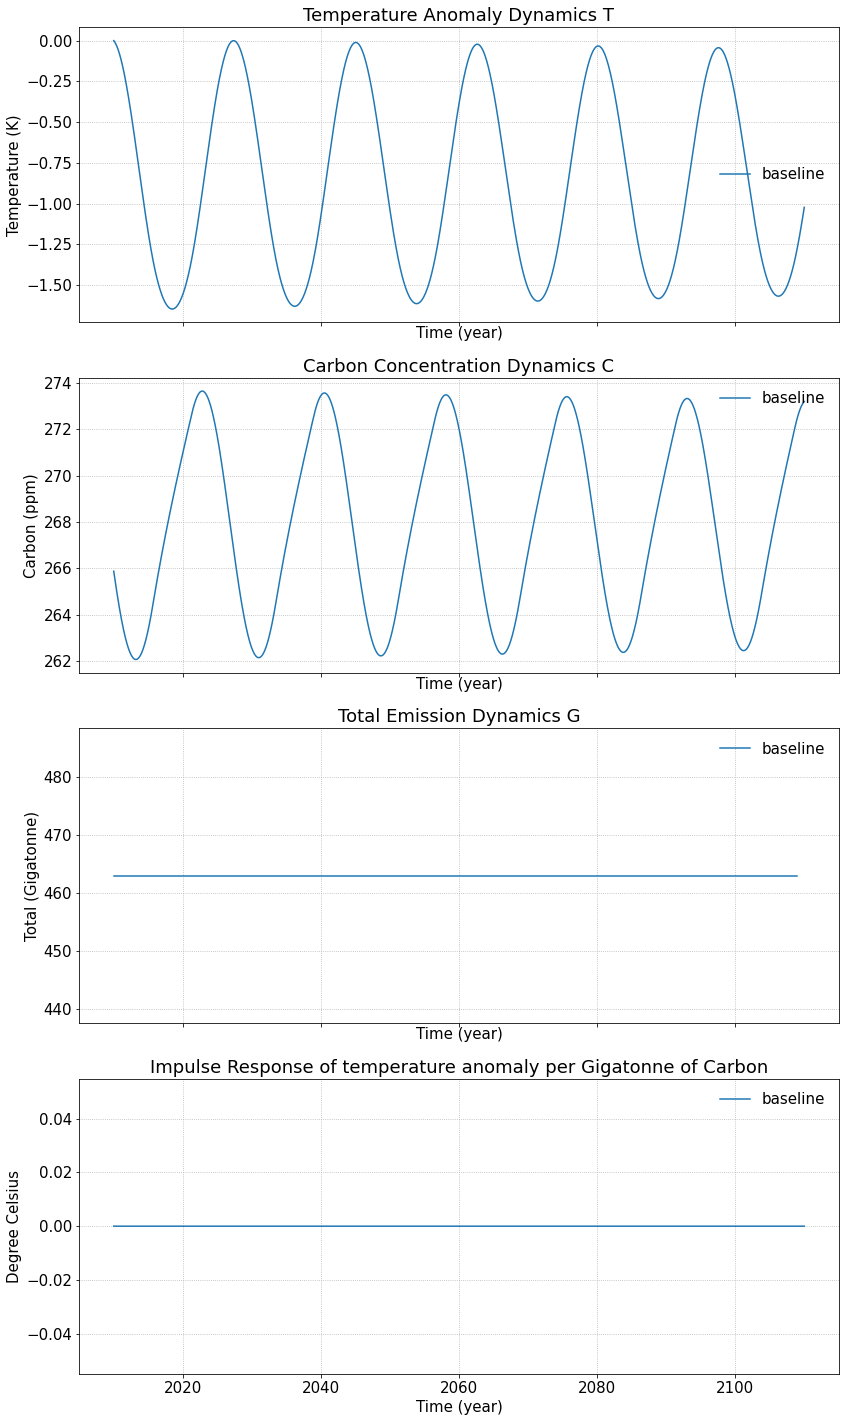

In [16]:

figwidth = 10

fig, axs = plt.subplots(4, 1, sharex=True, figsize=(12, 2 * figwidth))

time = 0 # 0 is the starting year, equivalent to 2010

tvBase, TvmidBase, CvBase, TeBase, CcBase, file_name, CsBase = model(time, 1, 0)
# print(CcBase)
TeBase = TeBase + 2010
tvBase = tvBase + 2010
# T_2010 = 288.05847735100105, C_2010 = 265.87438476522175, G_2010 = 102.03836999999999


axs[0].plot(tvBase, TvmidBase, label="baseline")
axs[0].set_xlabel('Time (year)')
axs[0].set_ylabel('Temperature (K)')
axs[0].set_title('Temperature Anomaly Dynamics T')
axs[0].grid(linestyle=':')
axs[0].legend()

axs[1].plot(tvBase, CvBase, label="baseline")
axs[1].set_xlabel('Time (year)')
axs[1].set_ylabel('Carbon (ppm)')
axs[1].set_title('Carbon Concentration Dynamics C')
axs[1].grid(linestyle=':')
axs[1].legend()

axs[2].plot(TeBase, CcBase*2.13, label="baseline")
axs[2].set_xlabel('Time (year)')
axs[2].set_ylabel('Total (Gigatonne)')
axs[2].set_title('Total Emission Dynamics G')
axs[2].grid(linestyle=':')
axs[2].legend()

axs[3].plot(tvBase, TvmidBase-TvmidBase, label="baseline")
axs[3].set_xlabel('Time (year)')
axs[3].set_ylabel('Degree Celsius')
axs[3].set_title(
    'Impulse Response of temperature anomaly per Gigatonne of Carbon')
axs[3].grid(linestyle=':')
axs[3].legend()

plt.tight_layout()
plt.show()
plt.close()

## Plot for other Impulse size and Length

## Change impulse size and length as you want

In [ ]:
# Don't change part
time = 0  # starting at 2010

# Can change part
length = 5  # length of year period selecting from 1, 5, 10
impulse = 50  # unit of Gtc selecting from 10 to 200


## Run the code

Tp = 289.2
Cp = 284.5


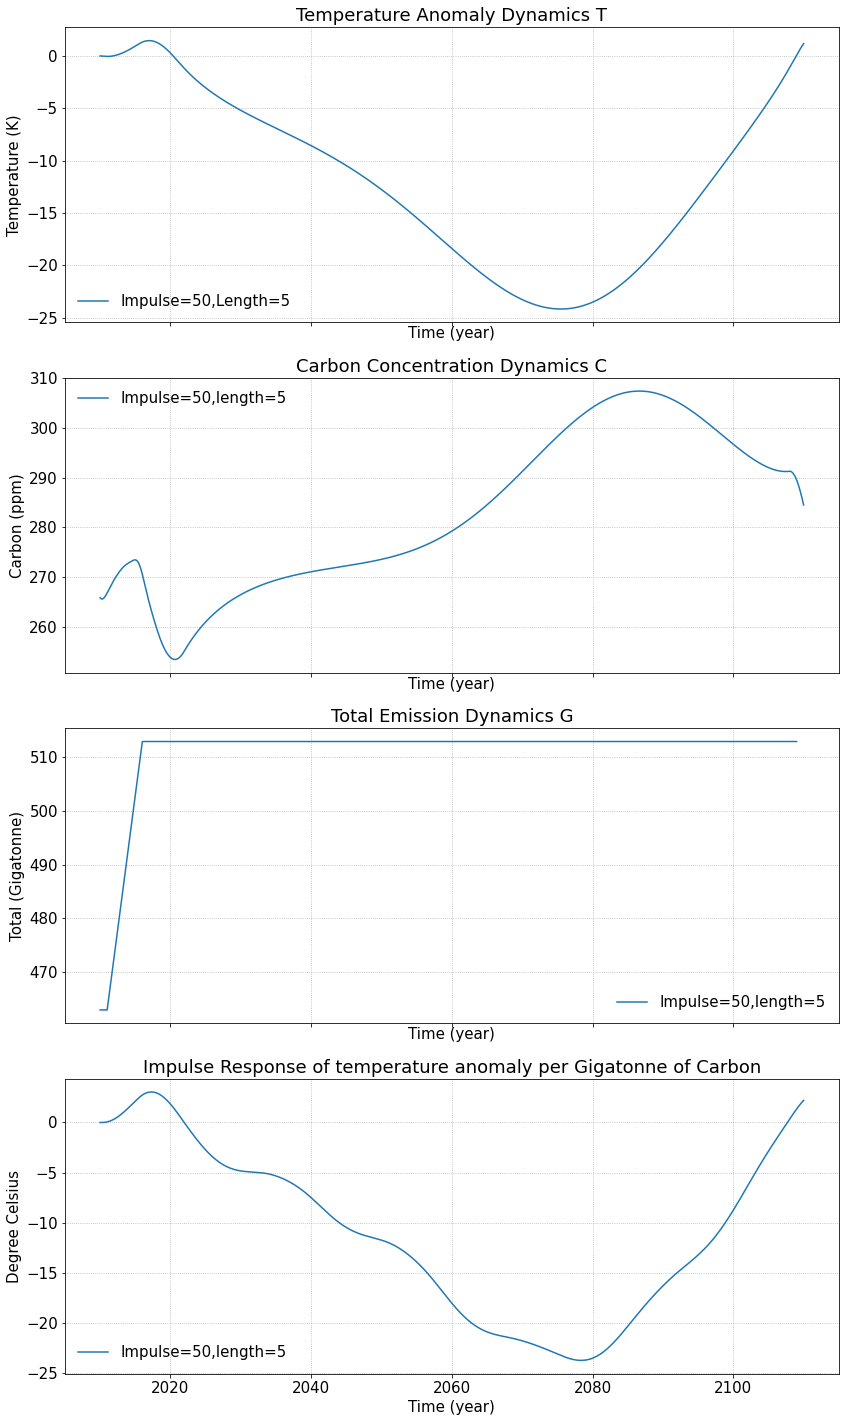

In [19]:

figwidth = 10

fig, axs = plt.subplots(4, 1, sharex=True, figsize=(12, 2 * figwidth))

tv, Tvmid, Cv, Te, Cc, file_name, Cs = model(time, length, impulse)
year = time + 2010

Te = Te + 2010
tv = tv + 2010


axs[0].plot(tv, Tvmid, label=f"Impulse={impulse},Length={length}")
axs[0].set_xlabel('Time (year)')
axs[0].set_ylabel('Temperature (K)')
axs[0].set_title('Temperature Anomaly Dynamics T')
axs[0].grid(linestyle=':')
axs[0].legend()

axs[1].plot(tv, Cv, label=f"Impulse={impulse},length={length}")
axs[1].set_xlabel('Time (year)')
axs[1].set_ylabel('Carbon (ppm)')
axs[1].set_title('Carbon Concentration Dynamics C')
axs[1].grid(linestyle=':')
axs[1].legend()

axs[2].plot(Te, Cc*2.13, label=f"Impulse={impulse},length={length}")
axs[2].set_xlabel('Time (year)')
axs[2].set_ylabel('Total (Gigatonne)')
axs[2].set_title('Total Emission Dynamics G')
axs[2].grid(linestyle=':')
axs[2].legend()

axs[3].plot(tv, Tvmid-TvmidBase,
            label=f"Impulse={impulse},length={length}")
axs[3].set_xlabel('Time (year)')
axs[3].set_ylabel('Degree Celsius')
axs[3].set_title(
    'Impulse Response of temperature anomaly per Gigatonne of Carbon')
axs[3].grid(linestyle=':')
axs[3].legend()

plt.tight_layout()
plt.show()
plt.close()